In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import main
from scipy.integrate import odeint

### Data Preprocessing

Data from https://data.europa.eu/euodp/en/data/dataset/covid-19-coronavirus-data/resource/260bbbde-2316-40eb-aec3-7cd7bfc2f590

In [2]:
data = main.getdata('data/timeseries25May.csv')

In [3]:
data = data.loc[data['country'].isin(['Netherlands', 'Belgium', 'Italy', 'Sweden', 'Denmark', 'Norway', 'Spain', 'United_Kingdom', 'Germany', 'Romania'])]

In [4]:
len(data['country'].unique())

10

Check for missing data

In [5]:
datelist = [date for date in pd.date_range(start='2019-12-31', end='2020-05-25') if len(data.loc[data['date'] == date]) != 10]

In [6]:
missing = [[(country, date.ctime()) for country in ['Netherlands', 'Belgium', 'Italy', 'Sweden', 'Denmark', 'Norway', 'Spain', 'United_Kingdom', 'Germany', 'Romania'] if country not in list(data.loc[data['date'] == date]['country'].values)] for date in datelist]

In [7]:
missing

[[('Romania', 'Tue Mar  3 00:00:00 2020')],
 [('Romania', 'Thu Mar  5 00:00:00 2020')],
 [('Spain', 'Mon May 25 00:00:00 2020')]]

Check for negative values

In [8]:
negative = data.loc[data['cases'] < 0]
negative

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp
16493,2020-04-19,19,4,2020,-713,410,Spain,ES,ESP,46723749.0,Europe
18258,2020-05-21,21,5,2020,-525,363,United_Kingdom,UK,GBR,66488991.0,Europe


In [9]:
data = data.drop(negative.index.values)

In [10]:
data.loc[data['cases'] < 0]

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp


In [13]:
data.head()

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp
18400,2019-12-31,31,12,2019,0,0,United_Kingdom,UK,GBR,66488991.0,Europe
4966,2019-12-31,31,12,2019,0,0,Denmark,DK,DNK,5797446.0,Europe
6990,2019-12-31,31,12,2019,0,0,Germany,DE,DEU,82927922.0,Europe
9337,2019-12-31,31,12,2019,0,0,Italy,IT,ITA,60431283.0,Europe
1979,2019-12-31,31,12,2019,0,0,Belgium,BE,BEL,11422068.0,Europe


Separate countries, make sure first record is equal to the first case date and reindex dataframes.

In [14]:
nl=no=be=ge=de=se=ro=it=uk=sp= None
countries = [[nl, 'Netherlands'], [no, 'Norway'], [be, 'Belgium'], [ge, 'Germany'], [de, 'Denmark'], [se, 'Sweden'], [ro, 'Romania'], [it, 'Italy'], [uk, 'United_Kingdom'], [sp, 'Spain']]
for country in countries: 
    country[0] = data.loc[data['country'] == country[1]]
    country[0].drop(country[0].loc[country[0]['cases']==0].index, inplace=True)
    country[0].reset_index(drop=True, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [15]:
dataframes, _ = zip(*countries)

In [16]:
dataframes[0].head()

,date,day,month,year,cases,deaths,country,geoId,countryCode,pop,continentExp
0,2020-02-28,28,2,2020,1,0,Netherlands,NL,NLD,17231017.0,Europe
1,2020-02-29,29,2,2020,1,0,Netherlands,NL,NLD,17231017.0,Europe
2,2020-03-01,1,3,2020,5,0,Netherlands,NL,NLD,17231017.0,Europe
3,2020-03-02,2,3,2020,6,0,Netherlands,NL,NLD,17231017.0,Europe
4,2020-03-03,3,3,2020,5,0,Netherlands,NL,NLD,17231017.0,Europe


### Seir Model

https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/, 
https://arxiv.org/pdf/2003.11150.pdf

Using the real parameters from the paper

In [33]:
mobilityDay = np.asarray([[0.08, 0.02, 0.15, 0.15, 0.15, 0.1, 0.15, 0.2], [0.08, 0.02, 0.15, 0.15, 0.15, 0.1, 0.15, 0.2], [0.3, 0.3, 0.1, 0.1, 0.05, 0.05, 0, 0.1], [0.05, 0, 0.2, 0.15, 0.15, 0.1, 0.2, 0.15], [0, 0, 0, 0, 0, 0, 0, 0]])
mobilityNight = np.asarray([[1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]])
mobilitySunday = np.asarray([[0.4, 0, 0, 0.6, 0, 0, 0, 0], [0.4, 0, 0, 0.6, 0, 0, 0, 0], [0.4, 0, 0, 0.6, 0, 0, 0, 0], [0.4, 0, 0, 0.6, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]])

beta = 0.1
betaArr = [0.08, beta, 1.5*beta, 1.5*beta, 1.5*beta, 1.5*beta, beta, 3*beta]
q = 3
delta = 0.15
d = 0.016
g = 0.0167
gammaR = 0.08
gammaD = 0.12
t = np.linspace(0, 500, 48000)
# N = np.unique(dataframes[0]['pop'].values)[0]
N = 1002
# I0 = dataframes[0]['cases'].values[0]
I0 = 0
R0 = D0 = 0
E0 = 2
S0 = N - I0 - R0 - E0 - D0
y0 = S0, E0, I0, R0, D0

In [34]:
def deriv(y, t, N, betaArr, mobility, delta, d, g, q, gammaR, gammaD):
    S, E, I, R, D = y
    dSdt = dEdt = dIdt = 0
#     for i in range(8):
#         dSdt = dSdt + (-betaArr[i]*S * mobility[:,i][0] *(I*mobility[:,i][2]-q*E * mobility[:,i][1])/N + d*E * mobility[:,i][1] + g*I * mobility[:,i][2])
#         dEdt = dEdt + (betaArr[i]*S * mobility[:,i][0]*(I*mobility[:,i][2]-q*E*mobility[:,i][1])/N - (delta + d)*E* mobility[:,i][1])
#         dIdt = dIdt + (delta*E *mobility[:,i][1] - (gammaR + gammaD)*I* mobility[:,i][2])

#     for i in range(8):
#         dSdt += (-betaArr[i]*S * mobility[:,i][0] *(I*mobility[:,i][2]+q*E * mobility[:,i][1])/N) + d*E*mobility[:,i][1] + g*R*mobility[:,i][3]
#         dEdt += betaArr[i]*S * mobility[:,i][0]*(I*mobility[:,i][2]+q*E*mobility[:,i][1])/N - (delta + d)*E* mobility[:,i][1]
#         dIdt += delta*E *mobility[:,i][1] - (gammaR + gammaD)*I* mobility[:,i][2]

    for i in range(8):
        dSdt += (-betaArr[i]*S * mobility[:,i][0] *(I*mobility[:,i][2] +q*E * mobility[:,i][1])/N) #+ d*E*mobility[:,i][1] + g*R*mobility[:,i][3]
        dEdt += betaArr[i]*S * mobility[:,i][0]*(I*mobility[:,i][2]+q*E*mobility[:,i][1])/N #- (delta + d)*E* mobility[:,i][1]
#         dIdt += delta*E *mobility[:,i][1] - (gammaR + gammaD)*I* mobility[:,i][2]
        
#     dSdt = -beta*S*(I-q*E)/N + d*E + g*R
#     dEdt = beta*S*(I-q*E)/N - (delta + d)*E
#     dIdt = delta*E - (gammaR + gammaD)*I
#     print(dSdt, dEdt, dIdt)

    dSdt += g*R + d*E
    dEdt += (- (delta + d)*E)
    
#     dSdt = (-beta*S  *(I +q*E)/N) + g*R + d*E
#     dEdt = beta*S *(I+q*E)/N - (delta + d)*E
    
    dIdt = delta*E - (gammaR + gammaD)*I
    dRdt = gammaR * I - g*R
    dDdt = gammaD*I
    return dSdt, dEdt, dIdt, dRdt, dDdt

Using the Euler method (allows for incorporating fe weekly patterns)

In [35]:
def euler(f,y0,a,b,h, S, E, I, R, D, mobility):

    t,y = a,y0
    while t <= b:
        t += h
        y += h * np.asarray(f(y, t, N, betaArr, mobility, delta, d, g, q, gammaR, gammaD))

        S.append(y[0])
        E.append(y[1])
        I.append(y[2])
        R.append(y[3])
        D.append(y[4])
    return S, E, I, R, D

No measures

In [36]:
i = 0
y = y0
S, E, I, R, D = [S0], [E0], [I0], [R0], [D0]
while i < 72:
    j = 0
    while j < 6:
        S, E, I, R, D = euler(deriv,y,0,0.24,0.01, S, E, I, R, D, mobilityDay)
        y = S[-1], E[-1], I[-1], R[-1], D[-1]
        S, E, I, R, D = euler(deriv,y,0,0.72,0.01, S, E, I, R, D, mobilityNight)
        y = S[-1], E[-1], I[-1], R[-1], D[-1]
        j+=1
        
    S, E, I, R, D = euler(deriv,y,0,0.24,0.01, S, E, I, R, D, mobilitySunday)
    y = S[-1], E[-1], I[-1], R[-1], D[-1]
    S, E, I, R, D = euler(deriv,y,0,0.72,0.01, S, E, I, R, D, mobilityNight)
    y = S[-1], E[-1], I[-1], R[-1], D[-1]
    
    i+=1

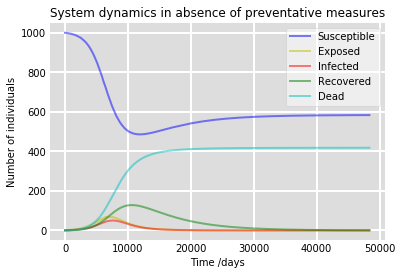

In [37]:
x = np.linspace(0, len(S), len(S))
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(x, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(x, E, 'y', alpha=0.5, lw=2, label='Exposed')
ax.plot(x, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(x, R, 'g', alpha=0.5, lw=2, label='Recovered')
ax.plot(x, D, 'c', alpha=0.5, lw=2, label='Dead')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number of individuals')
ax.set_title('System dynamics in absence of preventative measures')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

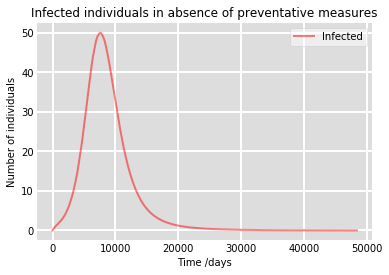

In [38]:
x = np.linspace(0, len(S), len(S))
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

ax.plot(x, I, 'r', alpha=0.5, lw=2, label='Infected')


ax.set_xlabel('Time /days')
ax.set_ylabel('Number of individuals')
ax.set_title('Infected individuals in absence of preventative measures')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

Closures after 2 weeks

In [23]:
i = 0
y = y0
S, E, I, R, D = [S0], [E0], [I0], [R0], [D0]
while i < 72:
#     if I[-1] > 5: 
    if i >=2:
        mobilityDay = np.asarray([[0.78, 0.02, 0.1, 0, 0, 0, 0.1, 0], [0.78, 0.02, 0.1, 0, 0, 0, 0.1, 0], [0.7, 0.3, 0, 0, 0, 0, 0, 0], [0.05, 0, 0.2, 0.15, 0.15, 0.1, 0.2, 0.15], [0, 0, 0, 0, 0, 0, 0, 0]])
        mobilityNight = np.asarray([[1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]])
        mobilitySunday = mobilityNight
        
#         beta = 0.08
    
    j = 0
    while j < 6:
        S, E, I, R, D = euler(deriv,y,0,0.24,0.01, S, E, I, R, D, mobilityDay)
        y = S[-1], E[-1], I[-1], R[-1], D[-1]
        S, E, I, R, D = euler(deriv,y,0,0.72,0.01, S, E, I, R, D, mobilityNight)
        y = S[-1], E[-1], I[-1], R[-1], D[-1]
        j+=1
        
    S, E, I, R, D = euler(deriv,y,0,0.24,0.01, S, E, I, R, D, mobilitySunday)
    y = S[-1], E[-1], I[-1], R[-1], D[-1]
    S, E, I, R, D = euler(deriv,y,0,0.72,0.01, S, E, I, R, D, mobilityNight)
    y = S[-1], E[-1], I[-1], R[-1], D[-1]
    
    i+=1

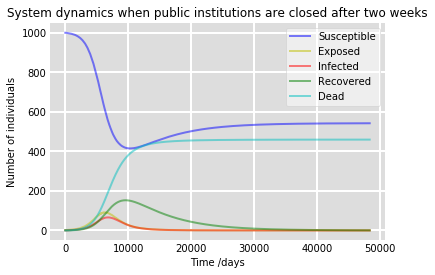

In [24]:
x = np.linspace(0, len(S), len(S))
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(x, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(x, E, 'y', alpha=0.5, lw=2, label='Exposed')
ax.plot(x, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(x, R, 'g', alpha=0.5, lw=2, label='Recovered')
ax.plot(x, D, 'c', alpha=0.5, lw=2, label='Dead')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number of individuals')
ax.set_title('System dynamics when public institutions are closed after two weeks')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

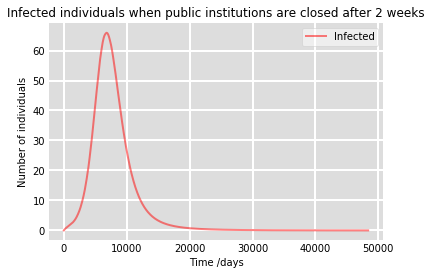

In [25]:
x = np.linspace(0, len(S), len(S))
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(x, I, 'r', alpha=0.5, lw=2, label='Infected')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number of individuals')
ax.set_title('Infected individuals when public institutions are closed after 2 weeks')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

Using method from https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/ (only works well for experimental parameters)

Experimental parameters: higher beta and gammaD

In [97]:
mobilityDay = np.asarray([[0.08, 0.02, 0.15, 0.15, 0.15, 0.1, 0.15, 0.2], [0.08, 0.02, 0.15, 0.15, 0.15, 0.1, 0.15, 0.2], [0.3, 0.3, 0.1, 0.1, 0.05, 0.05, 0, 0.1], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]])
mobilityNight = np.asarray([[1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]])
mobilitySunday = np.asarray([[0.4, 0, 0, 0.6, 0, 0, 0, 0], [0.4, 0, 0, 0.6, 0, 0, 0, 0], [0.4, 0, 0, 0.6, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]])

beta = 0.5
betaArr = [0.08, beta, 1.5*beta, 1.5*beta, 1.5*beta, 1.5*beta, beta, 3*beta]
q = 3
delta = 0.15
d = 0.016
g = 0.0167
gammaR = 0.08
gammaD = 0.3
t = np.linspace(0, 500, 48000)
# N = np.unique(dataframes[0]['pop'].values)[0]
N = 1002
I0 = dataframes[0]['cases'].values[0]
R0 = D0 = 0
E0 = 2
S0 = N - I0 - R0 - E0 - D0
y0 = S0, E0, I0, R0, D0

In [98]:
ret = odeint(deriv, y0, t, args=(N, betaArr, mobilityDay, delta, d, g, q, gammaR, gammaD))
S, E, I, R, D = ret.T

Attempt to repeat with different mobility matrix at different parts of the day

In [99]:
# i = 0
# while 0 <= len(t): 
#     if i ==0:
#         ret = odeint(deriv, y0, 1, args=(N, betaArr, mobilityDay, delta, d, g, q, gammaR, gammaD))
#         S, E, I, R, D = ret.T
#         y = S[-1], E[-1], I[-1], R[-1], D[-1]
        
#         ret = odeint(deriv, y0, 23, args=(N, betaArr, mobilityDay, delta, d, g, q, gammaR, gammaD))
#         S, E, I, R, D = ret.T
#         y = S[-1], E[-1], I[-1], R[-1], D[-1] 
        
#         ret = odeint(deriv, y, 72, args=(N, betaArr, mobilityNight, delta, d, g, q, gammaR, gammaD))
#         S, E, I, R, D = ret.T
#         y = S[-1], E[-1], I[-1], R[-1], D[-1]
        
#         j = 1
        
#     else: 
#         j = 0
        
#     while j < 7: 
#         ret = odeint(deriv, y, 24, args=(N, betaArr, mobilityDay, delta, d, g, q, gammaR, gammaD))
#         S, E, I, R, D = ret.T
#         y = S[-1], E[-1], I[-1], R[-1], D[-1]
    
#         ret = odeint(deriv, y, 72, args=(N, betaArr, mobilityNight, delta, d, g, q, gammaR, gammaD))
#         S, E, I, R, D = ret.T
#         y = S[-1], E[-1], I[-1], R[-1], D[-1]
#         j++
    
#     ret = odeint(deriv, y, 24, args=(N, betaArr, mobilitySunday, delta, d, g, q, gammaR, gammaD))
#     S, E, I, R, D = ret.T
#     y = S[-1], E[-1], I[-1], R[-1], D[-1]
    
#     ret = odeint(deriv, y, 72, args=(N, betaArr, mobilityNight, delta, d, g, q, gammaR, gammaD))
#     S, E, I, R, D = ret.T
#     y = S[-1], E[-1], I[-1], R[-1], D[-1]
    
#     i++

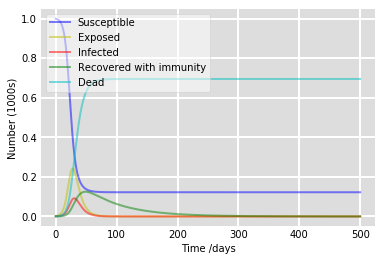

In [100]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, E/1000, 'y', alpha=0.5, lw=2, label='Exposed')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.plot(t, D/1000, 'c', alpha=0.5, lw=2, label='Dead')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()